# HAR ( Human Activity Recognition : 人間行動認識 )

　人間行動認識とは，カメラやセンサなどの様々な機器から得られた情報をもとに，人間の行動を学習･推定する認識技術分野のことである．今回は，スマホのIMU情報(姿勢･重力･角速度･ユーザの加速度)をもとに，ユーザの行動を下記の行動1～6の中から予測する．

1.	階段を降りている
1.	階段を登っている
1.	歩いている
1.	ジョギングしている
1.	座っている
1.	立っている  



## 1) データセットの準備


---

　まず，https://www.kaggle.com/malekzadeh/motionsense-dataset/ からダウンロードできるデータセットのzipファイルをこのipynbファイルと同じディレクトリに保存して下さい．


In [1]:
# zipを解凍
!unzip motionsense-dataset.zip

Archive:  motionsense-dataset.zip
replace A_DeviceMotion_data/A_DeviceMotion_data/dws_1/sub_1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

　解凍したデータセットには，24人の被験者の情報および，被験者が上記の6つの行動をとっている時のIMU情報(姿勢･重力･角速度･ユーザの加速度)が含まれている．

　ただし，各被験者が行動1～3は3回ずつ，行動4～6は2回ずつ測定を行っているため，合計24人×(3回×3 + 2回×3) = 360個のCSVファイルが含まれる．また，IMUのサンプリング周波数は50Hzであった．  
　360個のCSVファイルからトレーニングデータとテストデータを作成する．今回は，行動1～6それぞれ1回の試行をテストデータとし，残りをトレーニングデータとする．つまり，24人×6回 = 144個のCSVをテストデータに，24人×9回 = 216個のCSVをトレーニングデータとして扱う．

In [2]:
# 360個のCSVファイルからトレーニングデータとテストデータを作成
import numpy as np
import pandas as pd

# ==== data_subjects_info.csvに記載されている24人の被験者の情報を取り出す ===========================
def get_ds_infos():
  dss = np.genfromtxt("data_subjects_info.csv",delimiter=',')
  dss = dss[1:]   # 1行目を除く
  return dss      # 0:被験者ID, 1:体重, 2:身長, 3:年齢, 4:性別

# ==== 各被験者ごとに分かれているcsvファイルを1つにまとめ，時系列データを作成 ========================
def create_time_series_data(num_features, num_act_labels, num_gen_labels, act_labels, trial_id):
  ds_list = get_ds_infos()                                              # 被験者情報を取得
  dataset_columns = num_features + num_gen_labels + num_act_labels      # データセットの列数 = センサデータ数 + 性別ラベル数 + 行動ラベル数
  
  # 訓練データとテストデータを初期化(これを最後に返す)
  train_data = np.zeros((0, dataset_columns))
  test_data = np.zeros((0, dataset_columns))
  
  for i, sub_id in enumerate(ds_list[:, 0]):      # 被験者IDでループ
    for j, act in enumerate(act_labels):          # 行動ラベルでループ
      for trial in trial_id[act]:                 # 試行回数でループ
        fname = 'A_DeviceMotion_data/'+'A_DeviceMotion_data/'+act+'_'+str(trial)+'/sub_'+str(int(sub_id))+'.csv'
        raw_data = pd.read_csv(fname)                                     # csvから生データを取得
        raw_data = raw_data.drop(['Unnamed: 0'], axis=1)                  # ゴミデータ(1列目)を除く
        unlabel_data = raw_data.values  
        label_data = np.zeros((len(unlabel_data), dataset_columns))
        label_data[:,:-(num_act_labels + num_gen_labels)] = unlabel_data
        label_data[:,-1] = act_labels[act]
        label_data[:,-2] = int(ds_list[i,4])

        if trial < 11:          # 10回目以下の試行はトレーニングデータ
          train_data = np.append(train_data, label_data, axis = 0)
        else:                   # 11回目以上の試行はテストデータ
          test_data = np.append(test_data, label_data, axis = 0)

  return train_data , test_data

# ==== 訓練データとテストデータの作成 ===================================================================
num_features = 12       #    IMU情報   : 姿勢(ロール, ピッチ, ヨー), 重力(x, y, z), 角速度(x, y, z), ユーザ加速度(x,y,z)
num_act_labels = 1      # 行動ラベル数 : dws, ups, wlk, jog, sit, std
num_gen_labels = 1      #     性別     : 0/1(female/male)

act_labels = {"dws":1, "ups":2, "wlk":3, "jog":4, "sit":5, "std":6}
trial_id = {"dws":[1,2,11], "ups":[3,4,12], "wlk":[7,8,15], "jog":[9,16], "sit":[5,13], "std":[6,14]}    

# データ作成
train_ts, test_ts = create_time_series_data(num_features, num_act_labels, num_gen_labels, act_labels, trial_id)

print("トレーニングデータ形状:", train_ts.shape)
print("テストデータ形状:", test_ts.shape)

トレーニングデータ形状: (1081446, 14)
テストデータ形状: (331419, 14)


In [3]:
# CSVの保存
header = "attitude.roll,attitude.pitch,attitude.yaw,gravity.x,gravity.y,gravity.z,rotationRate.x,rotationRate.y,rotationRate.z,userAcceleration.x,userAcceleration.y,userAcceleration.z,Gender,CorrectAnserLabel"
fmt = "%.6f, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f, %.6f, %d, %d"
np.savetxt('train_raw.csv', train_ts, fmt=fmt, delimiter=',', header=header, comments="")
np.savetxt('test_raw.csv', test_ts, fmt=fmt, delimiter=',', header=header, comments="")
print("CSV saved successfully")

CSV saved successfully


　ひとまずCSVの保存まで完了したが，今回は重い計算したくないので，データの削減を行う．

In [4]:
# データセットが150MB程度あるので，5行に1行だけ使うことでデータを削減
import pandas as pd

# CSVファイルの読み込み
def load_data():
  return pd.read_csv("train_raw.csv"), pd.read_csv("test_raw.csv")

train_data_raw, test_data_raw = load_data()

# 5行に1行取り出し
train_data_reduction = train_data_raw.query('index % 5 == 0')
test_data_reduction = test_data_raw.query('index % 5 == 0')

# CSVの保存
train_data_reduction.to_csv("train.csv")
test_data_reduction.to_csv("test.csv")
print("CSV saved successfully")

CSV saved successfully


## 2) データの読み込みと加工


---



In [5]:
# まずは，CSVを読み込んで中身を確認
import numpy as np
import pandas as pd

# CSVファイルの読み込み
def load_data():
  return pd.read_csv("train.csv"), pd.read_csv("test.csv")

train_data, test_data = load_data()

# ゴミデータ(1列目)を削除
train_data = train_data.drop(['Unnamed: 0'], axis=1)
test_data = test_data.drop(['Unnamed: 0'], axis=1)

print("========= トレーニングデータ =============================================")
print(train_data,"\n")
print("============= テストデータ ===============================================")
print(test_data)

========= トレーニングデータ =============================================
        attitude.roll  attitude.pitch  ...  Gender  CorrectAnserLabel
0            1.528132       -0.733896  ...       1                  1
1            1.476302       -0.700807  ...       1                  1
2            1.434186       -0.693527  ...       1                  1
3            1.137867       -0.639672  ...       1                  1
4            0.916433       -0.655642  ...       1                  1
...               ...             ...  ...     ...                ...
216285      -0.245861       -1.449192  ...       0                  6
216286      -0.144484       -1.447449  ...       0                  6
216287      -0.054519       -1.450084  ...       0                  6
216288       0.014894       -1.445758  ...       0                  6
216289       0.068046       -1.445550  ...       0                  6

[216290 rows x 14 columns] 

============= テストデータ ===========================================

In [6]:
# データの欠損がないか確認
pd.set_option('display.max_columns', 14)
print(train_data.describe())
pd.reset_option('display.max_columns')

       attitude.roll  attitude.pitch   attitude.yaw      gravity.x  \
count  216290.000000   216290.000000  216290.000000  216290.000000   
mean       -0.180388       -1.027508      -0.126891       0.037576   
std         1.588032        0.450585       1.541152       0.332303   
min        -3.141551       -1.567685      -3.141588      -0.999612   
25%        -1.537733       -1.364888      -1.242785      -0.169055   
50%         0.101366       -1.193118      -0.138958       0.018564   
75%         0.901633       -0.781504       0.847209       0.250680   
max         3.141565        1.567175       3.141574       0.999901   

           gravity.y      gravity.z  rotationRate.x  rotationRate.y  \
count  216290.000000  216290.000000   216290.000000   216290.000000   
mean        0.784542      -0.124646        0.004909        0.014150   
std         0.297075       0.410916        1.320371        1.245072   
min        -0.999993      -0.999999      -16.020784      -17.232466   
25%         0.

In [0]:
# 各種定数の定義
num_features = 12       #    IMU情報   : 姿勢(ロール, ピッチ, ヨー), 重力(x, y, z), 角速度(x, y, z), ユーザ加速度(x,y,z)
num_act_labels = 1      # 行動ラベル数 : dws, ups, wlk, jog, sit, std
num_gen_labels = 1      #     性別     : 0/1(female/male)

act_labels = {"dws":1, "ups":2, "wlk":3, "jog":4, "sit":5, "std":6}

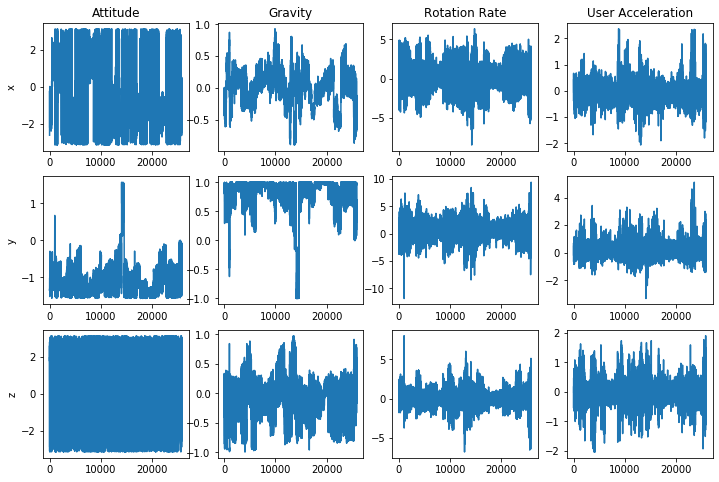

In [8]:
# データの中身を描画
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12.0, 8.0)

def get_column(act, type):
  data = train_data[train_data["CorrectAnserLabel"]==act_labels[act]][type].values
  length = len(train_data[train_data["CorrectAnserLabel"]==act_labels[act]][type].values)
  return length, data

act = "ups"    # {"dws", "ups", "wlk", "jog", "sit", "std"} から選択
num_rows = 3
num_columns = 4
types = ["attitude.roll","gravity.x","rotationRate.x","userAcceleration.x","attitude.pitch","gravity.y","rotationRate.y","userAcceleration.y","attitude.yaw","gravity.z","rotationRate.z","userAcceleration.z"]

for i, type in enumerate(types):
  data = get_column("ups", type)
  plt.subplot(num_rows, num_columns, i+1)
  plt.plot(range(data[0]), data[1])
  
  if i+1==1:
    plt.title("Attitude")
    plt.ylabel("x")
  elif i+1==2:
    plt.title("Gravity")
  elif i+1==3:
    plt.title("Rotation Rate")
  elif i+1==4:
    plt.title("User Acceleration")
  elif i+1==5:
    plt.ylabel("y")
  elif i+1==9:
    plt.ylabel("z")


　上のコードセルで描画したグラフは，被験者が階段を登っている時のスマホIMU情報である．センサの値を目で確認しても，ノイズが大きく，被験者がどんな行動を取っているのかよく分からないが，以下ではこのセンサの値から行動ラベルを予測していく．

In [0]:
# NumPy配列に変換
train_data = train_data.values
test_data = test_data.values

　では，CSVから取得したトレーニングデータとテストデータを，学習に用いる形状に加工する．IMU情報は時系列データであり，ある時刻でのデータとラベルだけでは意味を持たない．そこで，一定時間分のデータを1つのセクションとして扱い，セクションの集合を学習に用いるトレーニングデータとする．  
　セクションに分割する際に必要となるパラメータはセクションのサイズと，スライドサイズである．セクションサイズは1セクションに何サンプル含めるかを決めるパラメータで，サンプリング周波数が50Hzであることから，セクションサイズが50の場合は1セクションに1分間のデータが含まれる．(ただし，今回はデータを1/5に削減しているので，1セクション12秒間に相当する．) また，スライドサイズは1つ後のセクションをどれだけずらして開始するかを決めるパラメータであり，小さすぎると計算コストが高くなる可能性がある．   
　セクションサイズを50，スライドサイズを10として，セクションに分割するコードを以下に示す．

In [0]:
# 時系列データをセクションに分割する関数
def time_series_to_section(dataset, num_act_labels, num_gen_labels, size_sections, size_slide, standardize = False, **options):
  data = dataset[: , 0:-num_act_labels]           # IMUデータ+性別ラベルを取得
  act_labels = dataset[: , -(num_act_labels)]     # 行動ラベルを取得
 
  # === 標準化 =============================
  if standardize:
    if options:             # 引数で平均･分散を指定した場合
      mean = options.get("mean")
      std = options.get("std")
      print("トレーニングデータの平均と分散を用いてテストデータを標準化しました．")
    else:                   # 指定のない場合は標準化
      mean = data.mean(axis=0)
      std = data.std(axis=0)
      print("平均:",str(mean.mean()),", 分散:",str(std.mean()), "---> 標準化しました．")           
    data = (data - mean) / std
  else:
    print("標準化していません．")

  # あとで3次元配列に格納するために，一旦転置しておく
  data = data.T
          
  size_features = data.shape[0]
  size_data = data.shape[1]
  num_sections = 1 + ( (size_data - size_sections) // size_slide ) 
          
  # 1セクションのデータ形状を定義
  data_sections = np.zeros((num_sections, size_features, size_sections))
  act_secs_labels = np.zeros(num_sections)
   
  section_first_index = 0
  for count_section in range(num_sections):   # 各セクションの第1要素のindex
    section_first_index += size_slide     # セクションカウント
    if(section_first_index+size_sections > size_data):    # セクション数を超えたら終了     
      break
    if act_labels[section_first_index] != act_labels[section_first_index+size_sections-1]:    # セクション内で行動ラベルが全て一緒でない時は無視
      continue
    # data_sections = np.append(data_sections, data[0:size_features, section_first_index:section_first_index+size_sections].reshape(1,size_features,size_sections), axis=0)   # セクションデータのcount_section要素目に代入
    # act_secs_labels = np.append(act_secs_labels, act_labels[section_first_index].astype(int))
    data_sections[count_section] = data[0:size_features, section_first_index:section_first_index+size_sections]   # セクションデータのcount_section要素目に代入
    act_secs_labels[count_section] = act_labels[section_first_index].astype(int)
  
  return data_sections, act_secs_labels, mean, std

In [11]:
size_sections = 50   # セクションサイズ
size_slide = 10      # スライドサイズ

# 時系列データをセクション分割
print("分割後のセクション形状: (",num_features+num_gen_labels,"x",size_sections,")")
_X_train, _y_train, train_mean, train_std = time_series_to_section( train_data.copy(),
                                                                  num_act_labels,
                                                                  num_gen_labels,
                                                                  size_sections,
                                                                  size_slide,
                                                                  standardize = True )

_X_test, _y_test, test_mean, test_std = time_series_to_section( test_data.copy(),
                                                              num_act_labels,
                                                              num_gen_labels,
                                                              size_sections,
                                                              size_slide,
                                                              standardize = True,
                                                              mean = train_mean, 
                                                              std = train_std  )

y_train = np.delete(_y_train, np.where(_y_train==0))
X_train = np.delete(_X_train, np.where(_y_train==0), axis=0)
y_test = np.delete(_y_test, np.where(_y_test==0))
X_test = np.delete(_X_test, np.where(_y_test==0), axis=0)

print("トレーニングデータ形状:", X_train.shape)
print("テストデータ形状:", X_test.shape)

分割後のセクション形状: ( 13 x 50 )
平均: 0.0035300797597241063 , 分散: 0.749962379300086 ---> 標準化しました．
トレーニングデータの平均と分散を用いてテストデータを標準化しました．
トレーニングデータ形状: (20918, 13, 50)
テストデータ形状: (5922, 13, 50)


　セクションに分割できたので，トレーニングデータの一部をバリデーションデータに分割し，DatasetとDataLoaderを準備する．

In [12]:
# X_trainをトレーニングデータ･バリデーションデータに分割
import torch
from sklearn.model_selection import train_test_split

# trainを17000件のtrainingデータと3918件のvalidationデータに分割する
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, train_size=17000, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)

(17000, 13, 50)
(17000,)
(3918, 13, 50)
(3918,)


In [0]:
# 通常のNNは2次元形式で与えられても処理できないため，28x28の要素がある1次元配列に変換してからPyTorch形式に変換する
X_train_flatten = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2]) # 17000件の2次元データ（12×50）を17000件の1次元データ(600)に変換
X_valid_flatten  = X_valid.reshape(X_valid.shape[0], X_valid.shape[1]*X_valid.shape[2]) 
X_test_flatten  = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2]) 

X_train_torch = torch.tensor(X_train_flatten, dtype=torch.float) # dtype=torch.floatを忘れずに
X_valid_torch = torch.tensor(X_valid_flatten, dtype=torch.float) 
X_test_torch  = torch.tensor(X_test_flatten,  dtype=torch.float) 

# yについてもPyTorch形式に変換する
y_train_torch = torch.tensor(y_train, dtype=torch.long) # dtype=torch.longを忘れずに
y_valid_torch = torch.tensor(y_valid, dtype=torch.long) 
y_test_torch  = torch.tensor(y_test,  dtype=torch.long)

In [14]:
# datasetとdataloaderを用意

# XとYの組み合わせを保持してくれる便利なモノ
train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
valid_dataset = torch.utils.data.TensorDataset(X_valid_torch, y_valid_torch)
test_dataset  = torch.utils.data.TensorDataset(X_test_torch,  y_test_torch)

batch_size = 256 # 今回は256件のデータごとに学習を行う

# XとYの組み合わせを(batch_size)個ずつ出力する便利なモノ
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size)

for X, y in train_loader:
  print(X)
  print(y)
  break

tensor([[-0.3279, -0.2462, -0.2577,  ...,  0.8663,  0.8663,  0.8663],
        [ 1.1728,  1.2717,  1.3469,  ..., -1.1544, -1.1544, -1.1544],
        [ 0.6108,  0.3398,  0.2401,  ...,  0.8663,  0.8663,  0.8663],
        ...,
        [ 0.0903,  0.2408,  0.0995,  ..., -1.1544, -1.1544, -1.1544],
        [-1.1895, -1.1894, -1.1895,  ...,  0.8663,  0.8663,  0.8663],
        [ 1.0007,  1.1063,  1.1099,  ..., -1.1544, -1.1544, -1.1544]])
tensor([2, 4, 3, 6, 5, 6, 3, 5, 2, 3, 6, 5, 2, 5, 6, 5, 3, 5, 6, 1, 3, 4, 3, 3,
        2, 3, 4, 3, 6, 5, 5, 2, 2, 4, 3, 6, 3, 4, 6, 5, 2, 2, 5, 5, 3, 3, 6, 3,
        4, 2, 4, 6, 6, 3, 1, 3, 3, 4, 6, 5, 3, 3, 2, 3, 1, 5, 1, 5, 5, 6, 6, 5,
        5, 6, 5, 1, 3, 6, 6, 4, 2, 3, 6, 3, 2, 5, 3, 2, 2, 2, 1, 4, 5, 5, 3, 4,
        1, 5, 5, 3, 3, 3, 2, 2, 6, 6, 5, 5, 3, 3, 3, 1, 6, 2, 3, 1, 5, 3, 6, 2,
        2, 5, 3, 3, 5, 4, 2, 3, 5, 1, 5, 2, 6, 2, 3, 5, 3, 2, 3, 6, 3, 5, 5, 3,
        2, 2, 6, 4, 2, 3, 1, 5, 2, 6, 3, 2, 3, 2, 4, 6, 1, 5, 6, 3, 5, 1, 3, 4,
      

## 3) 多層NNによる予測


---

 まずは，多層ニューラルネットワークを用いて，IMU情報と性別から行動ラベルを予測する．



In [15]:
# リアルタイムで学習の状況を見る1つの方法として，livelossplotを用いる
!pip install livelossplot

In [0]:
# モデル model 、誤差関数 loss_fn、および最適化手法 opt を引数とすることで、汎用的に学習や予測を行えるコードを作成
import torch
from livelossplot import PlotLosses

device_GPU = torch.device("cuda:0") 

def calculate_model(model, loss_fn, opt, dataloader, device, mode="evaluate"):
  if mode == 'evaluate':
    model.eval() # 学習を行わない時は evaluate 状態にする

  sum_loss = 0
  correct = 0
  count = len(dataloader.dataset)
  
  for X, y in dataloader:
    y-=1
    X = X.to(device) # GPUへデータを転送
    y = y.to(device) # GPUへデータを転送
    y_pred = model(X) # Xからyを予測（softmaxを行う前の値が出力される）
    
    _, predicted = torch.max(y_pred.data, 1) # 6クラスのうち、予測確率最大のクラス番号を取得
    correct += (predicted == y).sum().item() # 予測に成功した件数をカウント（accuracy計算用）
    
    loss = loss_fn(y_pred, y)        # ミニバッチ内の訓練誤差の 平均 を計算
    sum_loss += loss.item()*len(y) # エポック全体の訓練誤差の 合計 を計算しておく
    
    if mode == 'update':
      # 重みの更新
      opt.zero_grad()
      loss.backward()
      opt.step()
    
  # エポック内の訓練誤差の平均値と予測精度を計算
  mean_train_loss = sum_loss / count
  train_accuracy = correct / count
  
  if mode == 'evaluate':
    model.train() # evaluate状態からtrain状態に戻しておく

  return mean_train_loss, train_accuracy    

def train(model, loss_fn, opt, train_loader, valid_loader, device, epoch=50):
  liveloss = PlotLosses() # 描画の初期化
  for i in range(epoch):
    train_loss, train_accuracy = calculate_model(model, loss_fn, opt, train_loader, device, mode='update')
    valid_loss, valid_accuracy = calculate_model(model, loss_fn,   _, valid_loader, device, mode='evaluate')
  
    # Visualize the loss and accuracy values.
    liveloss.update({
      'log loss': train_loss,
      'val_log loss': valid_loss,
      'accuracy': train_accuracy,
      'val_accuracy': valid_accuracy,
    })
    liveloss.draw()  
  print('Accuracy: {:.4f} (valid), {:.4f} (train)'.format(valid_accuracy, train_accuracy))
  return model # 学習したモデルを返す

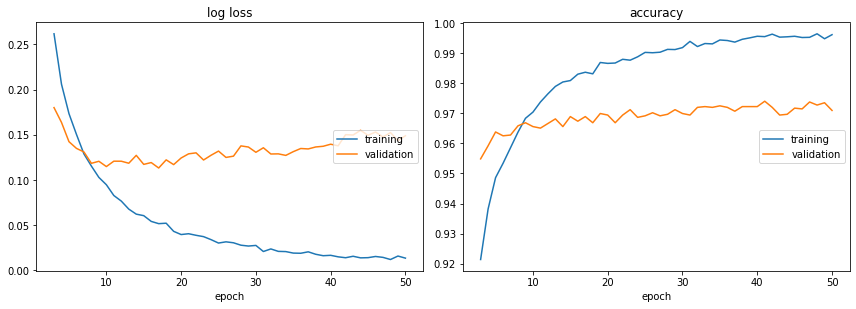

log loss:
training   (min:    0.012, max:    0.947, cur:    0.013)
validation (min:    0.113, max:    0.499, cur:    0.149)

accuracy:
training   (min:    0.662, max:    0.996, cur:    0.996)
validation (min:    0.859, max:    0.974, cur:    0.971)
Accuracy: 0.9709 (valid), 0.9961 (train)


In [17]:
# モデルの作成と学習の実行
torch.manual_seed(0)

model = torch.nn.Sequential(
  torch.nn.Linear(13*50, 512), 
  torch.nn.ReLU(),
  torch.nn.Dropout(p=0.5),
  torch.nn.Linear(512, 256), 
  torch.nn.ReLU(),
  torch.nn.Dropout(p=0.5),
  torch.nn.Linear(256, 6),    # 行動ラベル数は6 : dws, ups, wlk, jog, sit, std 
)
model.to(device_GPU) # deviceへモデルを転送

# 誤差関数と最適化手法を準備
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.2)

# 学習の実行
trained_model = train(model, loss_fn, optimizer, train_loader, valid_loader, device_GPU)

In [18]:
# 予測の実行
test_loss, test_accuracy = calculate_model(model, loss_fn,   _, test_loader, device_GPU, mode='evaluate')
# print(test_loss)
print("テストデータの予測正解率 : ", test_accuracy)

テストデータの予測正解率 :  0.9638635596082404


　以上より， 多層NNでは**96.39 %**で予測できることが分かった．

## 4) CVによるハイパーパラメータ探索


---

　多層ニューラルネットワークのハイパーパラメータ探索，特に今回はStochastic Gradient Decentの学習率`lr`の探索を行う．  
【注意】ハイパーパラメータ探索には4分程度かかります．


In [19]:
! [ ! -z "$COLAB_GPU" ] && pip install torch skorch

In [20]:
# クロスバリデーションからlrの最適な値を求める
from sklearn.model_selection import GridSearchCV
from skorch import NeuralNetClassifier
import torch.nn.functional as F

class Model(torch.nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    self.l1 = torch.nn.Linear(13*50, 512)
    self.relu1 = torch.nn.ReLU()
    self.drop1 = torch.nn.Dropout(0.5)
    self.l2 = torch.nn.Linear(512, 256)
    self.relu2 = torch.nn.ReLU()
    self.drop2 = torch.nn.Dropout(0.5)
    self.l3 = torch.nn.Linear(256, 6)

  def forward(self, x):
    y = self.l1(x)
    y = self.relu1(y)
    y = self.drop1(y)
    y = self.l2(y)
    y = self.relu2(y)
    y = self.drop2(y)
    y = self.l3(y)
    return y
    
model2 = Model()

net = NeuralNetClassifier(
    module=model2,
    max_epochs=20,
    optimizer=torch.optim.SGD,
    criterion= torch.nn.CrossEntropyLoss,
    lr=0.1,
)
np.random.seed(0)

# 辞書型が1つ入った配列
param_grid = [  
  { 
    "lr": [0.1, 0.15, 0.2, 0.25]
  } 
] 
grid_search_dt = GridSearchCV(net, param_grid, cv=4, verbose=2)   # 4-fold CVをしながら最適なモデルを決定する
grid_search_dt.fit(X_train_torch, y_train_torch-1)
print("\n", "最適ハイパーパラメータ : ", grid_search_dt.best_params_)
# print(grid_search_dt.best_score_)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV] lr=0.1 ..........................................................
  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.1054       0.7686        0.6841  0.7505
      2        0.5819       0.9165        0.3292  0.6544
      3        0.3578       0.9361        0.2263  0.6157
      4        0.2754       0.9435        0.1888  0.6840
      5        0.2180       0.9506        0.1721  0.6483
      6        0.1942       0.9502        0.1653  0.7553
      7        0.1643       0.9525        0.1540  0.6310
      8        0.1431       0.9545        0.1462  0.6592
      9        0.1336       0.9592        0.1421  0.7201
     10        0.1133       0.9592        0.1360  0.5870
     11        0.1060       0.9588        0.1367  0.6800
     12        0.0990       0.9620        0.1353  0.6422
     13        0.0851       0.9600        0.1297  0.6550
     14       

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.6s remaining:    0.0s


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        1.0993       0.7647        0.6879  0.7035
      2        0.5814       0.9024        0.3420  0.6593
      3        0.3640       0.9220        0.2394  0.6140
      4        0.2763       0.9329        0.1984  0.5936
      5        0.2294       0.9392        0.1745  0.6450
      6        0.1932       0.9435        0.1576  0.6269
      7        0.1648       0.9494        0.1505  0.6499
      8        0.1513       0.9514        0.1475  0.6687
      9        0.1317       0.9522        0.1410  0.6149
     10        0.1195       0.9557        0.1350  0.6450
     11        0.1163       0.9596        0.1329  0.6098
     12        0.0960       0.9565        0.1364  0.6103
     13        0.0873       0.9557        0.1309  0.7278
     14        0.0790       0.9608        0.1288  0.6154
     15        0.0762       0.9604        0.1272  0.6376
     16        0.0663       0.9

[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:  3.8min finished


  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8711       0.8853        0.3697  0.8630
      2        0.3569       0.9376        0.2150  0.8862
      3        0.2406       0.9429        0.1826  0.8474
      4        0.1918       0.9494        0.1607  0.8753
      5        0.1603       0.9518        0.1569  0.8080
      6        0.1388       0.9568        0.1422  0.8400
      7        0.1166       0.9606        0.1318  0.8164
      8        0.1048       0.9638        0.1252  0.8472
      9        0.0874       0.9650        0.1260  0.8107
     10        0.0785       0.9629        0.1307  0.8742
     11        0.0752       0.9665        0.1245  0.9179
     12        0.0674       0.9697        0.1173  0.8561
     13        0.0602       0.9665        0.1288  0.7895
     14        0.0516       0.9668        0.1280  0.8029
     15        0.0560       0.9591        0.1414  0.8569
     16        0.0498       0.9

　クロスバリデーションから最適な学習率 `lr` が0.15と求まったので，再度ハイパーパラメータを変更して学習する．

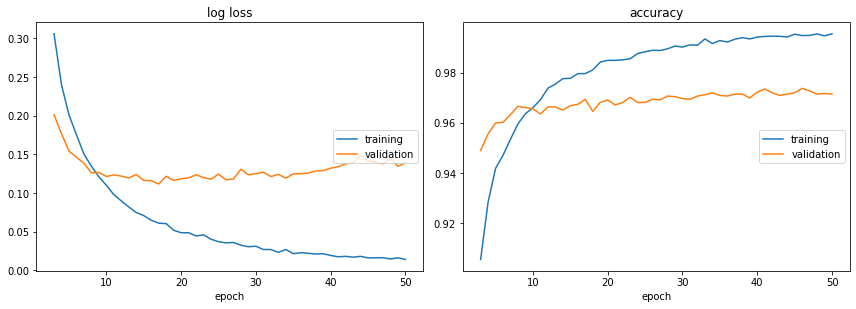

log loss:
training   (min:    0.014, max:    1.041, cur:    0.014)
validation (min:    0.112, max:    0.585, cur:    0.139)

accuracy:
training   (min:    0.633, max:    0.995, cur:    0.995)
validation (min:    0.825, max:    0.974, cur:    0.971)
Accuracy: 0.9714 (valid), 0.9955 (train)


In [21]:
torch.manual_seed(0)

model = torch.nn.Sequential(
  torch.nn.Linear(13*50, 512), 
  torch.nn.ReLU(),
  torch.nn.Dropout(p=0.5),
  torch.nn.Linear(512, 256), 
  torch.nn.ReLU(),
  torch.nn.Dropout(p=0.5),
  torch.nn.Linear(256, 6), 
)
model.to(device_GPU) # deviceへモデルを転送

# 誤差関数と最適化手法を準備
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.15)

# 学習の実行
trained_model = train(model, loss_fn, optimizer, train_loader, valid_loader, device_GPU)

In [22]:
# 予測の実行
test_loss, test_accuracy = calculate_model(model, loss_fn,   _, test_loader, device_GPU, mode='evaluate')
# print(test_loss)
print("テストデータの予測正解率 : ", test_accuracy)

テストデータの予測正解率 :  0.9655521783181358


　以上より，クロスバリデーションからハイパーパラメータを決定することで，汎化性能が上がり，予測正解率が**96.39 %**→**96.55 %**と少し向上していることが分かる．

## 5) CNNによる予測


---

　CNNは画像処理に良く使われる手法であるが，今回は時系列データを2次元的に扱うことで適用する．


In [23]:
# リシェイプ
X_train_4D = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_valid_4D  = X_valid.reshape(X_valid.shape[0], 1, X_valid.shape[1], X_valid.shape[2]) 
X_test_4D  = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2]) 
print(X_train_4D.shape)

(17000, 1, 13, 50)


In [0]:
# datasetおよびdataloaderの作成
batch_size = 256 # 今回は256件のデータごとに学習を行う

# training set
X_train_torch = torch.tensor(X_train_4D, dtype=torch.float) # dtype=torch.floatを忘れずに
y_train_torch = torch.tensor(y_train, dtype=torch.long)      # dtype=torch.longを忘れずに
train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
train_loader  = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)

# validation set
X_valid_torch = torch.tensor(X_valid_4D, dtype=torch.float)
y_valid_torch = torch.tensor(y_valid, dtype=torch.long)
valid_dataset = torch.utils.data.TensorDataset(X_valid_torch, y_valid_torch)
valid_loader  = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size)

# test set
X_test_torch = torch.tensor(X_test_4D, dtype=torch.float)
y_test_torch = torch.tensor(y_test, dtype=torch.long)
test_dataset = torch.utils.data.TensorDataset(X_test_torch, y_test_torch)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [0]:
# GPUの利用設定および学習･予測のための関数群の定義
import torch
from livelossplot import PlotLosses

device_GPU = torch.device("cuda:0") 

# モデルの更新と評価(modeによって切り替え)
def calculate_model(model, loss_fn, opt, dataloader, device, mode):
  if mode == 'evaluate':
    model.eval() # 学習を行わない時は evaluate 状態にする （補足資料※1）

  sum_loss = 0
  correct = 0
  count = len(dataloader.dataset)
  
  for X, y in dataloader:
    y-=1
    X = X.to(device) # GPUへデータを転送
    y = y.to(device) # GPUへデータを転送
    y_pred = model(X) # Xからyを予測（softmaxを行う前の値が出力される）
    
    _, predicted = torch.max(y_pred.data, 1) # 6クラスのうち、予測確率最大のクラス番号を取得
    correct += (predicted == y).sum().item() # 予測に成功した件数をカウント（accuracy計算用）
    
    loss = loss_fn(y_pred, y)        # ミニバッチ内の訓練誤差の 平均 を計算
    sum_loss += loss.item()*len(y) # エポック全体の訓練誤差の 合計 を計算しておく
    
    if mode == 'update':
      # 重みの更新
      opt.zero_grad()
      loss.backward()
      opt.step()
    
  # エポック内の訓練誤差の平均値と予測精度を計算
  mean_train_loss = sum_loss / count
  train_accuracy = correct / count
  
  if mode == 'evaluate':
    model.train() # evaluate状態からtrain状態に戻しておく

  return mean_train_loss, train_accuracy    

# 学習
def train(model, loss_fn, opt, train_loader, valid_loader, device, epoch=50):
  liveloss = PlotLosses() # 描画の初期化
  for i in range(epoch):
    train_loss, train_accuracy = calculate_model(model, loss_fn, opt, train_loader, device, mode='update')
    valid_loss, valid_accuracy = calculate_model(model, loss_fn,   _, valid_loader, device, mode='evaluate')
  
    # Visualize the loss and accuracy values.
    liveloss.update({
        'log loss': train_loss,
        'val_log loss': valid_loss,
        'accuracy': train_accuracy,
        'val_accuracy': valid_accuracy,
    })
    liveloss.draw()  
  print('Accuracy: {:.4f} (valid), {:.4f} (train)'.format(valid_accuracy, train_accuracy))
  return model # 学習したモデルを返す

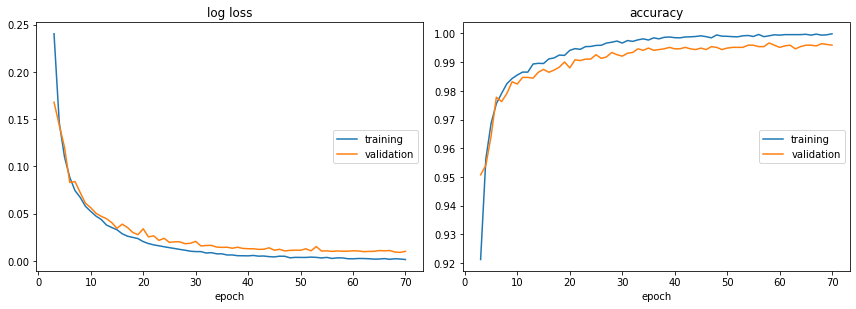

log loss:
training   (min:    0.002, max:    0.832, cur:    0.002)
validation (min:    0.009, max:    0.469, cur:    0.010)

accuracy:
training   (min:    0.673, max:    1.000, cur:    1.000)
validation (min:    0.832, max:    0.997, cur:    0.996)
Accuracy: 0.9959 (valid), 0.9999 (train)


In [26]:
# モデルの作成と学習の実行
torch.manual_seed(0) # 学習結果の再現性を担保

cnn = torch.nn.Sequential(
    torch.nn.Conv2d(1, 16, (3, 3), padding=2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(16, 32, (3, 3), padding=2),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Conv2d(32, 64, (3, 3)),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2),
    torch.nn.Dropout(0.2),
    torch.nn.Flatten(), 
    torch.nn.Linear(384, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.2),
    torch.nn.Linear(128, 6),
)
cnn.to(device_GPU)

# 誤差関数と最適化手法を準備
loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01)
optimizer = torch.optim.Adagrad(cnn.parameters(), lr=0.01)

# 学習の実行
trained_model = train(cnn, loss_fn, optimizer, train_loader, valid_loader, device_GPU, epoch=70)

In [27]:
# 予測の実行
test_loss, test_accuracy = calculate_model(cnn, loss_fn,   _, test_loader, device_GPU, mode='evaluate')
# print(test_loss)
print("テストデータの予測正解率 : ", test_accuracy)

テストデータの予測正解率 :  0.9547450185748058


　以上より，CNNでは **95.47 %**で 予測可能であることが分かった．

## 6) RNNによる予測


---

　RNNはネットワークにループを作成することで，時系列データに対する逐次的な予測や，可変長データに対する単一予測を行う際に利用できるニューラルネットワークの1手法である．今回は，IMUの時系列データを扱っているので，RNNを適用することを考える．  
　まずは，DatasetおよびDataLoaderを作成する．

In [28]:
size_sections = 50   # セクションサイズ
size_slide = 10      # スライドサイズ

# 時系列データをセクション分割
print("分割後のセクション形状: (",num_features+num_gen_labels,"x",size_sections,")")
_X_train, _y_train, train_mean, train_std = time_series_to_section( train_data.copy(),
                                                                  num_act_labels,
                                                                  num_gen_labels,
                                                                  size_sections,
                                                                  size_slide,
                                                                  standardize = True )

_X_test, _y_test, test_mean, test_std = time_series_to_section( test_data.copy(),
                                                              num_act_labels,
                                                              num_gen_labels,
                                                              size_sections,
                                                              size_slide,
                                                              standardize = True,
                                                              mean = train_mean, 
                                                              std = train_std  )

y_train = np.delete(_y_train, np.where(_y_train==0))
X_train = np.delete(_X_train, np.where(_y_train==0), axis=0)
y_test = np.delete(_y_test, np.where(_y_test==0))
X_test = np.delete(_X_test, np.where(_y_test==0), axis=0)

print("トレーニングデータ形状:", X_train.shape)
print("テストデータ形状:", X_test.shape)

分割後のセクション形状: ( 13 x 50 )
平均: 0.0035300797597241063 , 分散: 0.749962379300086 ---> 標準化しました．
トレーニングデータの平均と分散を用いてテストデータを標準化しました．
トレーニングデータ形状: (20918, 13, 50)
テストデータ形状: (5922, 13, 50)


In [29]:
# 通常のNNは2次元形式で与えられても処理できないため，28x28の要素がある1次元配列に変換してからPyTorch形式に変換する
X_train_flatten = X_train.reshape(X_train.shape[0], 1, X_train.shape[1]*X_train.shape[2]) # 17000件の2次元データ（12×50）を17000件の1次元データ(600)に変換
X_test_flatten  = X_test.reshape(X_test.shape[0], 1, X_test.shape[1]*X_test.shape[2]) 
X_train_torch = torch.tensor(X_train_flatten, dtype=torch.float) # dtype=torch.floatを忘れずに
X_test_torch  = torch.tensor(X_test_flatten,  dtype=torch.float) 


# yについてもPyTorch形式に変換する
y_train_torch = torch.tensor(y_train, dtype=torch.long) # dtype=torch.longを忘れずに
y_test_torch  = torch.tensor(y_test,  dtype=torch.long)

# datasetとdataloaderを用意
# XとYの組み合わせを保持してくれる便利なモノ
train_dataset = torch.utils.data.TensorDataset(X_train_torch, y_train_torch)
test_dataset  = torch.utils.data.TensorDataset(X_test_torch,  y_test_torch)

# XとYの組み合わせを(batch_size)個ずつ出力する便利なモノ
batch_size = 1 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)

for X, y in train_loader:
  print(X.shape)
  print(y.shape)
  # print(X)
  # print(y)
  break

torch.Size([1, 1, 650])
torch.Size([1])


　次に，時系列データに対して1つの出力を得るために，RNNの最後の出力のみを取り出して利用するモデルを構築する．

In [0]:
import torch

# 最後の出力だけを次の層に渡すRNN
class lastoutputRNN(torch.nn.Module):
  def __init__(self, input_size, output_size):
    super(lastoutputRNN, self).__init__() # 初期化のおまじない
    
    # 学習すべき重みがあるものをここに全て定義
    self.rnn = torch.nn.RNN(input_size, output_size, num_layers=1, batch_first=True)
  
  # 予測時の計算を定義
  def forward(self, input):
    outs_rnn, hiddens = self.rnn(input, self.initHidden()) # ひとまず複数の 出力 h を全て受け取る
    last_out_rnn = outs_rnn[-1] # 最後の出力 h_r を抜き出す
    return last_out_rnn # 次の層に渡す

  # RNNの隠れ層の初期値を準備する補助関数
  def initHidden(self):
    return torch.zeros(1, 1, self.rnn.hidden_size)

　では実際にRNNを用いて学習を行っていく．  
【注意】以下のコードは実行に3分程度かかります．

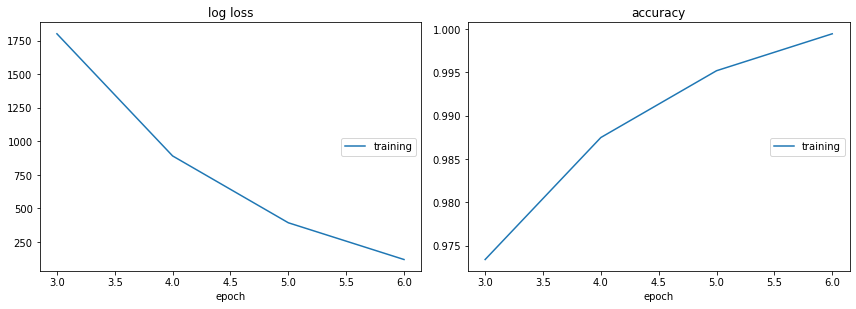

log loss:
training   (min:  119.319, max: 9346.757, cur:  119.319)

accuracy:
training   (min:    0.857, max:    0.999, cur:    0.999)
計算時間 :  177.7418041229248
Accuracy: 0.9994 (train)


In [31]:
import json
import random
from livelossplot import PlotLosses # livelossplotのインストールを忘れずに（AI7.1.4参照）
import numpy as np

torch.manual_seed(0) # 実行結果を再現させる
np.random.seed(0)    # data_shuffle()のためにNumPyの乱数も指定する

###### Sequentialによるモデルの作成
# 入力：文字列のone-hot表現
# 出力：入力の文字列が「どの言語らしいか」を示す値（各言語ごとに実数値を出力）
model = torch.nn.Sequential(
  lastoutputRNN(650, 128), 
  torch.nn.Linear(128, 6)
)

###### 誤差関数と最適化手法の定義
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

###### 学習本体
liveloss = PlotLosses() # 描画の準備

import time
start = time.time() # 計算開始時刻

for epoch in range(6):  # 6 epoch 学習する
  total_train_loss = 0.0
  num_train_correct = 0
  # X, y = data_shuffle(X_train, y_train)

  for Xi_torch, yi_torch in train_loader:
    yi_torch -= 1
    y_pred = model(Xi_torch)    # 予測の実施
    _, predicted = torch.max(y_pred.data, 1)
    num_train_correct += (predicted == yi_torch).sum().item()
    
    # 予測の誤差を計算（交差エントロピー誤差）
    # print(Xi_torch)
    # print(y_pred)
    # print(yi_torch)
    loss = loss_fn(y_pred, yi_torch)
    total_train_loss += loss.item()
    
    # 誤差逆伝播法による重みの更新
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # このepoch全体での予測精度 (accuracy) を計算
  train_accuracy = num_train_correct / len(y_train)

  # livelossplotの描画
  liveloss.update({
   'log loss': total_train_loss,
    'accuracy': train_accuracy,
  })
  liveloss.draw()

end = time.time() # 計算終了時刻
print("計算時間 : ", end - start) # 差を秒単位で計算
    
# 最後のepochにおける訓練データの予測精度を出力
print('Accuracy: {:.4f} (train)'.format(train_accuracy))

In [32]:
# テストデータの予測正解率を算出
num_test_correct = 0
for X, y in test_loader:
  y-=1
  pred = model(X)                                 # 予測の実施
  _, predicted = torch.max(pred.data, 1)                # 最も確率の高かったクラスを求める
  if predicted == y:
    num_test_correct += 1

test_accuracy = num_test_correct / len(y_test)
print(test_accuracy)

0.9113475177304965


　以上より，RNNでは **91.13 %**で 予測可能であることが分かった．